<font size=6>**Lab 5: Introduction to Recurrent Neural Networks**</font>

<div style="border: 1px solid lightgray; padding: 10px; background-color: #f9f9f9;">

<font size=1>

    Paolo Bonfini, 2025. All rights reserved.

This work is the intellectual property of `Paolo Bonfini`. All content produced in this notebook is original creation of the author unless specified otherwise. Unauthorized use, reproduction, or distribution of this material, in whole or in part, without explicit permission from the author, is strictly prohibited.
</font>
</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">


In this notebook we will explore **Recurrent Neural Networks** (**RNNs**).

We will get there step by step $-$ we will:
1. Perform data preparation $\rightarrow$ **windowing**
2. Apply **simpler** ML algorithms to windowed data
3. Train **shallow RNNs**
4. Peform **recursive forecasting**

# Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set seaborn style
sns.set_theme(style="darkgrid")  # Options: "white", "dark", "whitegrid", "darkgrid", "ticks"

# Global settings for Matplotlib
plt.rcParams.update({
    "figure.figsize": (8, 4),   # Default figure size (width, height)
    "axes.titlesize": 14,       # Title font size
    "axes.labelsize": 12,       # Label font size
    "xtick.labelsize": 10,      # X-axis tick font size
    "ytick.labelsize": 10,      # Y-axis tick font size
    "legend.fontsize": 10,      # Legend font size
    "font.size": 10,            # General font size
    "figure.autolayout": True,  # Auto-layout for better spacing
    "axes.grid": True,          # Show grid
    "grid.alpha": 0.3,          # Grid transparency
    "lines.linewidth": 2,       # Default line width
    "lines.markersize": 6,      # Default marker size
    "figure.dpi": 100,          # Resolution of figures
    "savefig.dpi": 300,         # Resolution for saved figures
    "axes.spines.top": False,   # Remove top spine
    "axes.spines.right": False, # Remove right spine
    "text.color": "gray",   # Set all text color
    "axes.labelcolor": "gray",  # Set axis labels color
    "xtick.color": "gray",  # Set x-axis tick labels color
    "ytick.color": "gray",  # Set y-axis tick labels color
    "legend.edgecolor": "gray",  # Set legend edge color
    "legend.labelcolor": "gray"  # Set legend text color    
})

In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os

# Current path ---------------------------------------------------------------
script_path = str(Path().absolute())
print('Current path:', script_path)
#-----------------------------------------------------------------------------

# Results folder -------------------------------------------------------------
path_results = script_path + "/results"
# folder where the current run's results shall be nested in

if not os.path.exists(path_results):
    os.makedirs(path_results)
    print('Folder "%s" created.' % os.path.basename(path_results))
#-----------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')
# keep it quiet, jeez!

Current path: /media/work/classes/Machine Learning pt2 #253 - 2025/Labs/L05


# Data

In [191]:
from datetime import datetime, timedelta
# Get yesterday's date in the format YYYY-MM-DD
yesterday = (datetime.today() - timedelta(days=2)).strftime("%Y-%m-%d")
print(yesterday)

2025-03-17


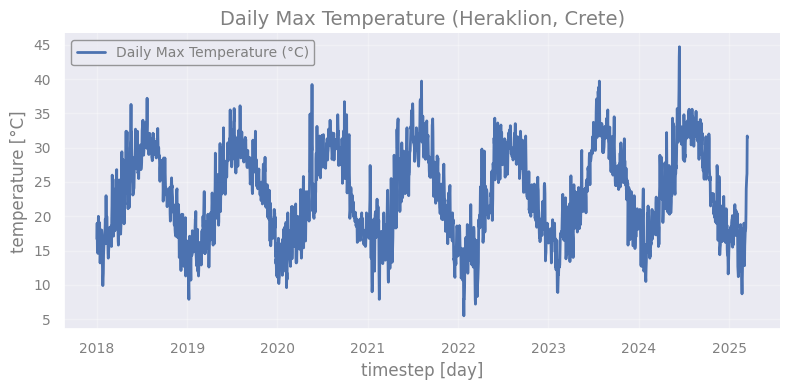

Total data points: 2632


In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import io

# Define the API endpoint for temperature data (example using Open-Meteo API for historical data)
url = "https://archive-api.open-meteo.com/v1/archive?latitude=35.34&longitude=25.13&daily=temperature_2m_max&timezone=Europe/Athens&start_date=2018-01-01&end_date="+yesterday

# Download the data
response = requests.get(url)
data = response.json()

# Extract temperature data
times  = data['daily']['time']
series = data['daily']['temperature_2m_max']

# Convert to pandas DataFrame
df = pd.DataFrame({'time': pd.to_datetime(times), 'temperature': series})

# Plot Temperature Data
plt.plot(df['time'], df['temperature'], label='Daily Max Temperature (°C)', color='C0')
plt.xlabel('timestep [day]')
plt.ylabel('temperature [°C]')
plt.title('Daily Max Temperature (Heraklion, Crete)')
plt.legend()
plt.show()

print('Total data points: %s' % len(series))

# Data preparation for ML models

Let's suppose we want to train a ML model for a **forecasting** task $-$ e.g. an AR(2) model:

$$Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + C + \epsilon_t \tag{1}$$ 

In a  ML framework: **forecast** = **regression** $\rightarrow$ Let's think in terms of **regressors**

If we want to use e.g., a `scikit-learn` regressor, we e need to setup the usual **data matrices**:

| X                 |  | y             |
|------------------|:-:|--------------|
| (#samples, #features) | | (#samples) |

$\rightarrow$ we need to create **samples** and **features**!
 
We need to **see** the model in Equation 1 as:

$$y = \phi_1 X_1 + \phi_2 X_2 $$ 

where:
- $y = Y_t$
- $X_1 = Y_{t-1}$
- $X_2 = Y_{t-2}$
- ($C$ and $\epsilon_t$ omitted for simplicity)

That is, we need to think:

> **feature** = **time lag**

If we want to predict **multiple timesteps** in the future:

| X                 |  | y             |
|------------------|:-:|--------------|
| (#samples, #features) | | (#samples, #horizon) |

That is, we need to think:

> **forecast horizon** = **size of y**

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

<u>**The issue**</u>

The problem is, we start from a **series** of dimensions (#timesteps) $-$ We need to perform the <u>re-arrangement</u>:<br>

<div align="center">
    <b>series</b> (#timesteps) $\rightarrow$ <b>X</b> (#samples, #features), <b>y</b> (#samples, #horizon)
</div>

**Q:** How can we **re-organize** the data?

## Windowing

> **Windowing** is a technique where a fixed-size segment (**window**) is slided across the series to create multiple training sample.

We can define tow contiguous windows:
- **predictor window** (number of desired **features**)
- **target window** (number of desired **timesteps to forecast**)

In [5]:
%%time
%%capture
#^ To avoid plotting to cell

gif_path = "results/sliding_window_animation.gif"

def create_animation(series, win_predictor=25, win_target=8, step=1):
    """Create a windowing animation GIF and save it to file."""
    # Reduce data for quick calculation
    series_ = series[:100]
    
    # Recalculate frames
    num_frames_optimized = (len(series_) - win_predictor - win_target) // step
    
    # Create the optimized figure
    fig, ax = plt.subplots(figsize=(8, 4))
    line, = ax.plot([], [], "gray", alpha=0.5, label="Series")
    pred_line, = ax.plot([], [], "C0", label="Predictor window")
    target_line, = ax.plot([], [], "C3", label="Target window")
    
    # Set fixed axis limits for efficiency
    ax.set_xlim(0, len(series_))
    ax.set_ylim(np.min(series_) - 1, np.max(series_) + 1)
    ax.legend()
    
    # Initialization function
    def init():
        line.set_data(range(len(series_)), series_)
        pred_line.set_data([], [])
        target_line.set_data([], [])
        return pred_line, target_line
    
    # Update function for animation
    def update(frame):
        start_idx = frame * step
        pred_x = list(range(start_idx, start_idx + win_predictor))
        pred_y = series_[start_idx:start_idx + win_predictor] if start_idx + win_predictor < len(series_) else []
    
        target_x = list(range(start_idx + win_predictor, start_idx + win_predictor + win_target))
        target_y = series_[start_idx + win_predictor:start_idx + win_predictor + win_target] if start_idx + win_predictor + win_target < len(series) else []
    
        pred_line.set_data(pred_x, pred_y)
        target_line.set_data(target_x, target_y)
        return pred_line, target_line
    
    # Create the optimized animation
    ani_optimized = animation.FuncAnimation(fig, update, frames=num_frames_optimized, init_func=init, blit=True, repeat=True)
    
    # Save the optimized animation
    ani_optimized.save(gif_path, writer="pillow", fps=5)

# create_animation(series);

CPU times: user 12.3 ms, sys: 5.09 ms, total: 17.3 ms
Wall time: 16 ms


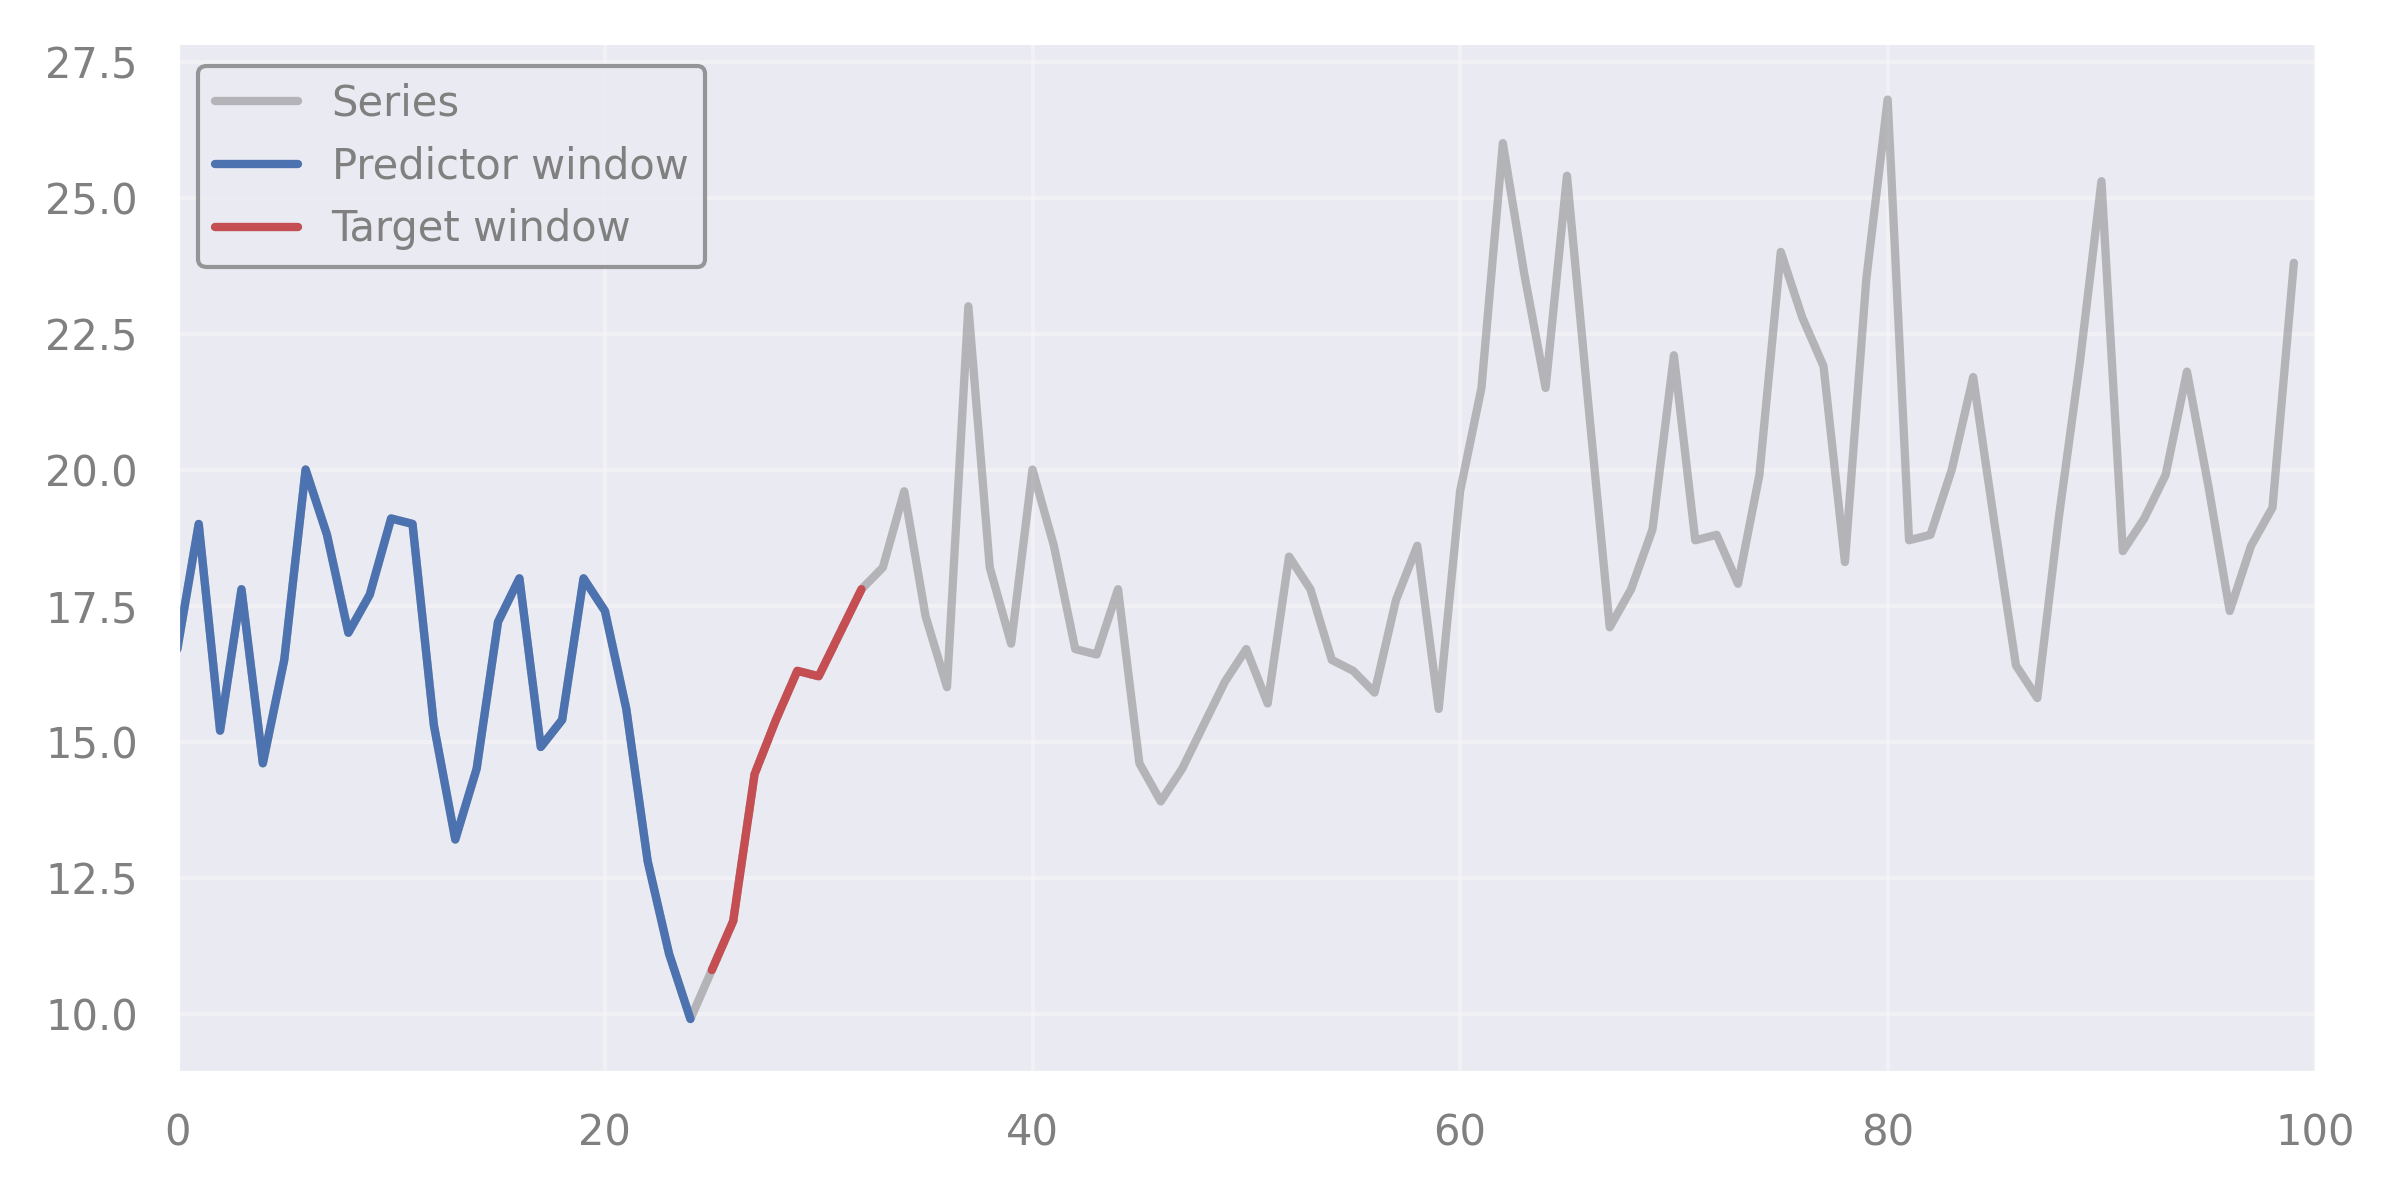

In [6]:
from IPython.display import display, Image

# Display the optimized GIF path
display(Image(filename=gif_path, width=800))

At each **shift**, a new **sample** is generated:
- the values in the **predictor** window are appended to the matrix $X$
- the values in the **target** window are appended to the matrix $y$

$\rightarrow$ Yes, this causes subsequent samples (rows) in $X$ to be **correlated**, since they contain overlapping data.

In [7]:
def windowing(series, win_predictor, win_target):
    """
    Generates predictor-target pairs using a sliding window approach.
    
    Parameters:
        series (array-like): The time series data.
        win_predictor (int): Number of timesteps in the predictor window.
        win_target (int): Number of timesteps in the target window.

    Returns:
        X (numpy array): Array of predictor windows.
        y (numpy array): Array of target windows.
    """
    X, y = [], []
    for i in range(len(series) - win_predictor - win_target + 1):
        X.append(series[i : i + win_predictor])
        y.append(series[i + win_predictor : i + win_predictor + win_target])
    
    return np.array(X), np.array(y)

win_predictor = 10
win_target    = 5
X, y = windowing(series, win_predictor, win_target)

print("Series length: %s" % len(series))
print(" '--> X shape:", X.shape)
print(" '--> y shape:", y.shape)

# Display individual samples
# for i in range(len(X)):
#     print(f"Sample {i+1}:")
#     print(f"Predictors: {X[i]} -> Targets: {y[i]}\n")

Series length: 2632
 '--> X shape: (2618, 10)
 '--> y shape: (2618, 5)


<u>**Observation**</u>

We inevitably obtain **fewer** samples than the initial timesteps<br>
(_because each sample requires a full predictor and target window, reducing the number of valid points_)

<div class="alert alert-block alert-warning" style="margin-top: 20px">

##  In-class Exercise [30 min]

**Objective:** Code a windowing function that reduces correlation between the generated samples.

**Task:** Edit the `windowing` function above to skip one or more timesteps at every shift.

_In particular, you must:_

1. **Copy-paste** the function and rename it to `windowing_edit`
2. Add a **parameter** `step` (default=1)
3. Make it so, that two consecutive samples are **separated** by `step` timesteps<br>
    _(i.e., the predictor/target window slides by `step` instead of 1, at every iteration)_
4. **Apply windowing and plot** the first 3 windows to check if your function works as intended

**Hint**: The `step` is <u>not</u> the space between predictor and target, but the shift between iterations!

</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

_Our solution_

In [8]:
def windowing_edit(series, win_predictor, win_target, step=1):
    """
    Generates predictor-target pairs using a sliding window approach with adjustable step size.
    
    Parameters:
        series (array-like): The time series data.
        win_predictor (int): Number of timesteps in the predictor window.
        win_target (int): Number of timesteps in the target window.
        step (int, default=1): Number of timesteps to skip between consecutive samples.
    
    Returns:
        X (numpy array): Array of predictor windows.
        y (numpy array): Array of target windows.
    """
    X, y = [], []
    for i in range(0, len(series) - win_predictor - win_target + 1, step):
        X.append(series[i : i + win_predictor])
        y.append(series[i + win_predictor : i + win_predictor + win_target])
    
    return np.array(X), np.array(y)

win_predictor = 10
win_target    = 5
step          = 2
X, y = windowing_edit(series, win_predictor, win_target, step)

print("Series length: %s" % len(series))
print(" '--> X shape:", X.shape)
print(" '--> y shape:", y.shape)
    

Series length: 2632
 '--> X shape: (1309, 10)
 '--> y shape: (1309, 5)


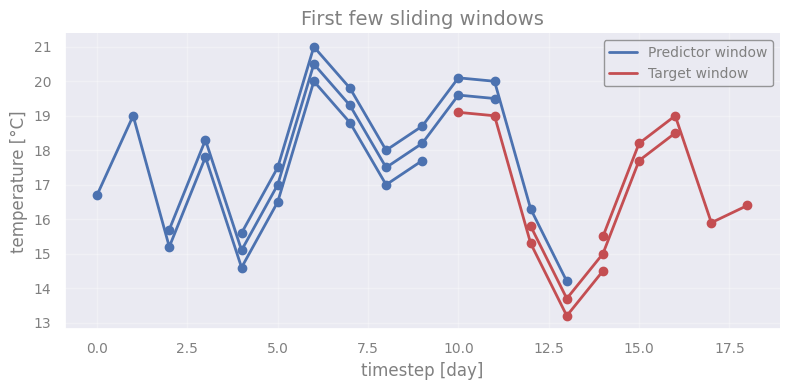

In [9]:
# Plot the first 3 predictor-target windows with vertical offset

offset = 0.5  # Artificial vertical offset

for i in range(3):
    pred_x = range(i * step, i * step + win_predictor)
    pred_y = X[i] + i * offset  # Apply vertical offset

    target_x = range(i * step + win_predictor, i * step + win_predictor + win_target)
    target_y = y[i] + i * offset  # Apply vertical offset

    plt.plot(pred_x, pred_y, "C0", label="Predictor window" if i == 0 else None)
    plt.scatter(pred_x, pred_y, c= "C0")
    plt.plot(target_x, target_y, "C3", label="Target window" if i == 0 else None)
    plt.scatter(target_x, target_y, c= "C3")

plt.title("First few sliding windows")
plt.xlabel('timestep [day]')
plt.ylabel('temperature [°C]')
plt.legend()
plt.show()

## How many lags shall I consider?

In principle? _Who knows_?

- The size of the **target window** $\rightarrow$ Depends on the application (_how far we want to forecast_)
- The size of the **predictor window** $\rightarrow$ It's a hyperparameter that shall be cross-validated
 
_BUT .._

We can use **PACF** for a **guess**.

<div class="alert alert-block alert-warning" style="margin-top: 20px">

##  In-class Exercise [15 min]

**Objective:** Guess how many previous timesteps are relevant to predict the next.

**Task:** Construct a PACF.

_In particular, you must:_

1. Retrieve the previous lecture **notebook** where the PACF was presented
2. Grab the relevant code and generate the **PACF** plot
3. Guess how many lags are **relevant**

</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

_Our solution_

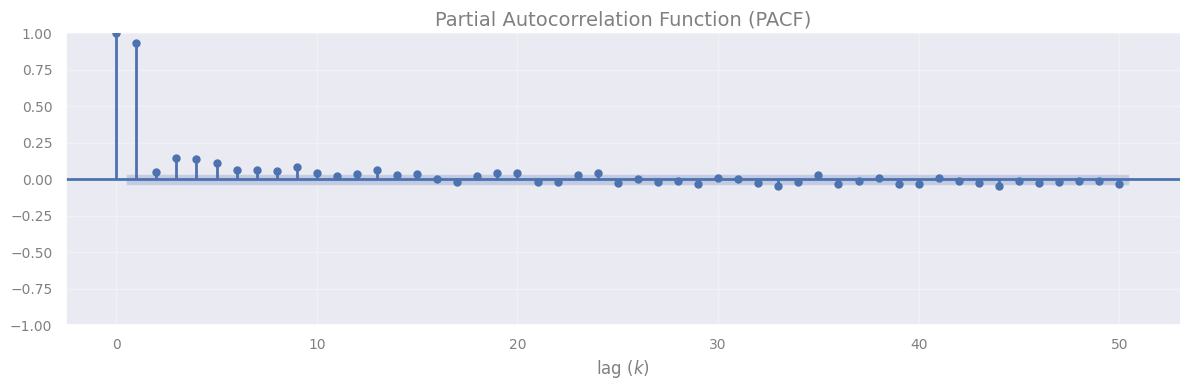

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

lags = 50
'''As for the ACf, we can analyze less lags than the maximum'''

fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(series, lags=lags, method='ywm', ax=ax)
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("lag ($k$)")
plt.show()

<u>**Observations**</u>

- Lag 2 seems to be not relevant, but we can use the first 5 lags<br>
  $\rightarrow$ _We can window the data using_ `win_predictor` = 5
- PACF refers to the prediction at the next timestep, i.e. $t+1$<br>
  $\rightarrow$ _If we want to predict a whole horizon $\mathbf{y} =[(t+1), \dots (t+h)]$, PACF does not provide the whole picture_

# Using ML models

## Linear Regression

Here, we use `LinearRegression` by `scikit-learn` as a simple usage case for ML regressors (_they all work the same_).

We will:
- predict only the next timestep: `win_target` = 1
- use the predictor window inferred from PACF: `win_predictor` = 5

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# A. Windowing
X, y = windowing(series, win_predictor=5, win_target=1)
print('Number of windows (i.e., samples): %s' % len(X))

# B. Define model
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Because standardizing is always good habit!
    ("regressor", LinearRegression())
])

# C. Fit
pipeline.fit(X, y)
yhat = pipeline.predict(X)

# D. Evaluate the model
MSE = mean_squared_error(y, yhat)
print("Mean Squared Error: %.2f" % MSE)

Number of windows (i.e., samples): 2627
Mean Squared Error: 4.92


<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

... **After windowing**, it is just like in the tutorials!

<u>**IMPORTANT (1):**</u>
> Each prodictor window ($X_i$) is now a **sample**, and each target window ($y_i$) the corresponding **target**!

<u>**IMPORTANT (2):**</u>
> Here, `yhat` is <u>not</u> the recursed prediction, but the **next-step** (`win_target` = 1) prediction for each window!

In fact, it has as many entries as number of windows:

In [12]:
print('Number of windows (i.e., samples): %s' % X.shape[0])
print('Number of predicted targets: %s' % yhat.shape[0])

Number of windows (i.e., samples): 2627
Number of predicted targets: 2627


## Train/Test split

But, we forgot to split **train/test**.

**Q:** How do we split, in time series? $\rightarrow$ _We cannot mix past with future timesteps_

**A:** We do <u>not shuffle</u>! $\rightarrow$ _Place the first e.g. 80% timesteps in the train, and the rerst in test_.

<div class="alert alert-block alert-warning" style="margin-top: 20px">

##  In-class Exercise [25 min]

**Objective:** Perform the proper model assessment.

**Task:** Re-run the fit of the Linear Regressor and assess the performance.

_In particular, you must:_

1. **Split** `series` in `series_train` (80%) and `series_test` (20%)
2. **Plot** train and test to be sure you did it right
3. Perform **windowing** on the two splits, <u>separately</u><br>

   X_train, y_train $\leftarrow$ windowing of `series_train`<br>
   X_test, y_test $\leftarrow$ windowing of `series_test`<br>

4. Train on train, test on test (**golden rule**)

</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

_Our solution_

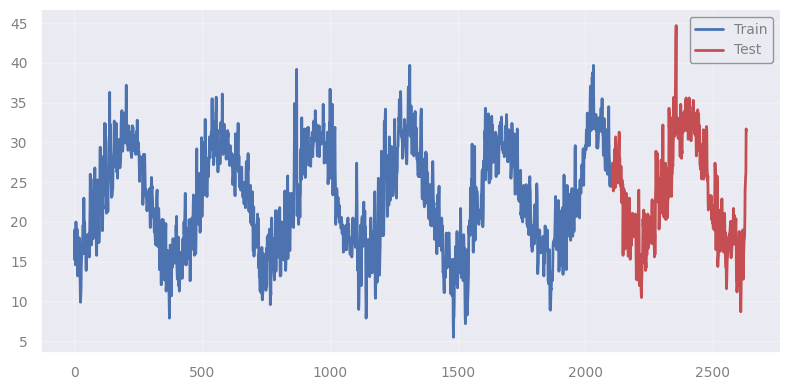

X_train: (2100, 5) | y_train: (2100, 1)
X_test:  (522, 5)  | y_test:  (522, 1)
Mean Squared Error (test): 4.83


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 1. Train/Test split
# Brute force:
train_size = int(0.8 * len(series))  # 80% for training
series_train, series_test = series[:train_size], series[train_size:]
# OR:
# Using sklearn, with a trick and paying attention _not_ to shuffle
series_train, series_test, _, _ = train_test_split(series, series, test_size=0.2, shuffle=False, random_state=42)

# 2. Plot sets
timesteps_train = np.arange(len(series_train))
timesteps_test  = np.arange(len(series_test)) + len(series_train)
plt.plot(timesteps_train, series_train, c='C0', label='Train')
plt.plot(timesteps_test,  series_test,  c='C3', label='Test')
plt.legend()
plt.show()

# 3. Windowing
X_train, y_train = windowing(series_train, win_predictor=5, win_target=1)
X_test,  y_test  = windowing(series_test,  win_predictor=5, win_target=1)
print('X_train: %-9s | y_train: %s' % (X_train.shape, y_train.shape))
print('X_test:  %-9s | y_test:  %s' % (X_test.shape,  y_test.shape))

# 4.A. Define model
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Because standardizing is always good habit!
    ("regressor", LinearRegression())
])

# 4.B. Fit
pipeline.fit(X_train, y_train)
yhat_test = pipeline.predict(X_test)

# 4.C. Evaluate the model
MSE_test = mean_squared_error(y_test, yhat_test)
print("Mean Squared Error (test): %.2f" % MSE_test)

# Recurrent Neural Networks (RNNs)

> **RNNs** were introduced to process sequential data by maintaining a memory of past inputs<br>

<u>**Key intuition**</u>
- In non-RNN networks each input neuron (timestep) has its own independent weight
- RNNs **reuse the same weight matrices at every timestep**, making it inherently sequential

A RNN layer may be **represented** like this:

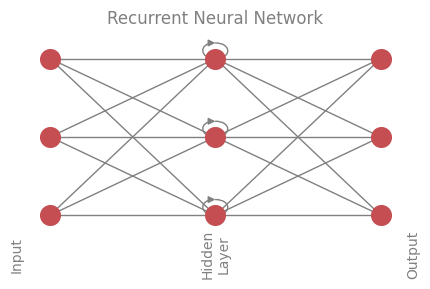

In [14]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define node positions
positions = {
    "i1": (0, 2), "i2": (0, 1), "i3": (0, 0),
    "h1": (1, 2), "h2": (1, 1), "h3": (1, 0),
    "o1": (2, 2), "o2": (2, 1), "o3": (2, 0)
}

# Add nodes
G.add_nodes_from(positions.keys())

# Add edges to form the layers of the RNN
edges = [
    ("i1", "h1"), ("i1", "h2"), ("i1", "h3"),
    ("i2", "h1"), ("i2", "h2"), ("i2", "h3"),
    ("i3", "h1"), ("i3", "h2"), ("i3", "h3"),

    ("h1", "o1"), ("h1", "o2"), ("h1", "o3"),
    ("h2", "o1"), ("h2", "o2"), ("h2", "o3"),
    ("h3", "o1"), ("h3", "o2"), ("h3", "o3"),

    # Recurrent connections (loops)
    ("h1", "h1"), ("h2", "h2"), ("h3", "h3")
]

G.add_edges_from(edges)

plt.figure(figsize=(4, 2))
nx.draw(
    G, pos=positions, with_labels=False, node_color="C3", 
    edge_color="grey", node_size=200, font_size=10, arrows=False
)

# Add labels for each layer
plt.text(-0.2, -0.5, "Input", fontsize=10, ha='center', va='center', color='grey', rotation=90)
plt.text(+1.0, -0.5, "Hidden\nLayer", fontsize=10, ha='center', va='center', color='grey', rotation=90)
plt.text(+2.2, -0.5, "Output", fontsize=10, ha='center', va='center', color='grey', rotation=90)

plt.title("Recurrent Neural Network", fontsize=12)
plt.show()

... where the arch represent the fact that the information is passed $T$ times (time lags) inside the same neuron.

## Hidden state

To keep track of past values, each RNN cell (layer) has a **hidden state** $h_t$.

At each time step $t$, the hidden state is **updated** using:
- the input at that time step $x_t$
- the previous hidden state $h_{t-1}$

Therefore, $h_t$ is <u>both</u> passed back to the cell for **next step**, and used as **output**.

<table><tr>
    <td width=640>
        <img src=attachment:5cd43bf9-5849-4198-a482-9585fb7eb724.png>
        <center>
            <br>
            Figure 1.  An RNN "cell".
            <br>
            (Image by <a href="https://github.com/dvgodoy/dl-visuals/?tab=readme-ov-file">CC BY</a>)
        </center>
    </td>
</tr></table>

Mathematically, the hidden state **value** is calculated as:

$$h_t = f(W_h h_{t-1} + W_x x_t + b_h)$$

where:
- $W_h$ is the weight matrix for the hidden state
- $W_x$ is the weight matrix for the input
- $b_h$ is the bias term
- $f(.)$ is the activation function (_e.g., Tanh_)

<table><tr>
        <td width="260" style="text-align: center;">
            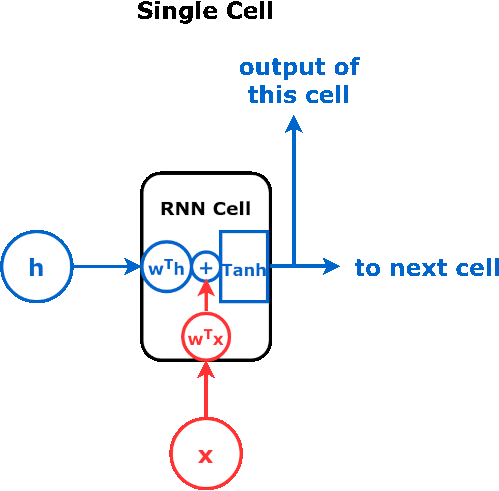
        </td>
</tr></table>
<table><tr>
    <td width="600" style="text-align: center;">
        <br>
        Figure 2. Update function for the hidden state of an RNN cell.
        <br>
        (Image by <a href="https://dvgodoy.github.io/dl-visuals/RNNs/">dvgodoy</a> /
        <a href="https://creativecommons.org/licenses/by/4.0/">CC BY</a>)
    </td>
</tr></table>

<u>**Sizes**</u>

- The input $x_t$ represents **features** at a single timestep (_e.g., a scalar if 1D, or a vector if multi-dimensional_)
> $x_t$ $\leftrightarrow$ (#features)
- The hidden state $h_t$ represents learned representations of past inputs and is a vector of **neuron values**
> $h_t$ $\leftrightarrow$ (#neurons)

In general $\rightarrow$ size ($x_t$) != size ($h_t$)

<u>**Example:**</u> 

- 1D input (_dimension $x_t$ = 1; e.g., today's temperature_)
- hidden layer with 5 neurons (_dimension $h_t$ = 5_)

$$
h_t =
\begin{bmatrix}
h_{t,1} \\
h_{t,2} \\
h_{t,3} \\
h_{t,4} \\
h_{t,5}
\end{bmatrix}
= f \left[ W_h
\begin{bmatrix}
h_{t-1,1} \\
h_{t-1,2} \\
h_{t-1,3} \\
h_{t-1,4} \\
h_{t-1,5}
\end{bmatrix}
+ W_x
\begin{bmatrix}
x_t
\end{bmatrix}
+ b_h \right]
$$
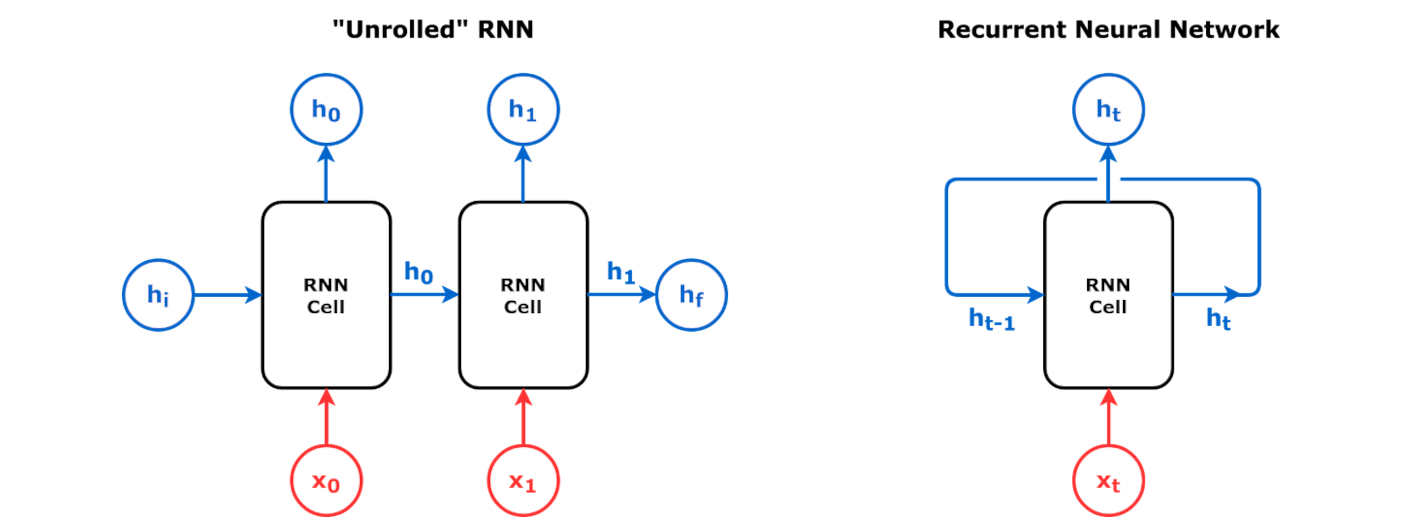

<u>**Example:**</u> 

- 3D input (_dimension $x_t$ = 3; e.g., today's temperature, humidity, and cloudiness_)
- hidden layer with 5 neurons (_dimension $h_t$ = 5_)

$$
h_t =
\begin{bmatrix}
h_{t,1} \\
h_{t,2} \\
h_{t,3} \\
h_{t,4} \\
h_{t,5}
\end{bmatrix}
= f \left[W_h
\begin{bmatrix}
h_{t-1,1} \\
h_{t-1,2} \\
h_{t-1,3} \\
h_{t-1,4} \\
h_{t-1,5}
\end{bmatrix}
+W_x
\begin{bmatrix}
x_{t,1} \\
x_{t,2} \\
x_{t,3}
\end{bmatrix}
+b_h\right]
$$

## Backpropagation in RNNs

- In Forward NNs $\rightarrow$ gradients are computed layer by layer
- In RNNs $\rightarrow$ **errors must be propagated through time** due to the recurrent structure

The total loss is the _sum of losses at each timestep_:

$$L = \sum_{t=1}^{T} \ell(y_t, \hat{y}_t)$$

where $\ell(y_t, \hat{y}_t)$ is the loss at timestep $t$. 

The gradient of $L$ with respect to parameters (e.g., $W_h$) requires applying the **chain rule recursively** through time $\rightarrow$ **Backpropagation Through Time (BPTT)**:

$$ \frac{\partial L}{\partial W_h} = \sum_{t=1}^{T} \frac{\partial L}{\partial h_t} \cdot \frac{\partial h_t}{\partial W_h} \tag{3} $$

<u>**Warning:**</u>

> Because of Equation 3, RNNs chain _way more_ gradients than Forward NNs.

$\rightarrow$ Potential **vanishing or exploding gradients** due to repeated multiplication of Jacobian matrices

PS: Use saturating activation functions (_i.e. functions slowly flattening_) like **Tanh** cautiously ...

## At the end, we still need windows (_not a Linux joke_)

The RNN does <u>not</u> inherently rely on a fixed window—instead, it processes the sequence **dynamically, timestep by timestep**.

_... On paper, but..._

In practical implementations, $T$ timesteps are formatted as an **input window** in the data matrix $X$.

<u>Why?</u>
- **Gradient stability** in BPTT (_prevent uncontrolled gradient propagation in BPTT_) 
- Deep Learning models require **fixed-size inputs** for mini-batch training
- A single long sequence can be transformed into **multiple training samples**

## Tensorflow example

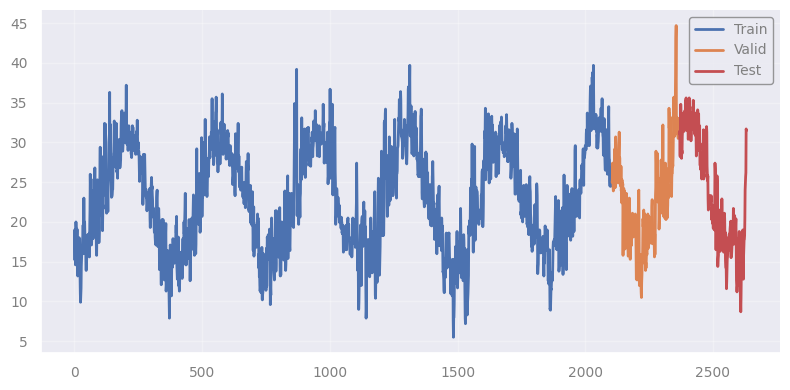

X_train: (2100, 5) | y_train: (2100, 1)
X_valid: (258, 5)  | y_valid: (258, 1)
X_test:  (259, 5)  | y_test:  (259, 1)


In [47]:
# 1. Train/Valid/Test split
train_size = int(0.8 * len(series))   # 80% for training
valid_size = int(0.1 * len(series))   # 10% for validation
test_size  = len(series) - train_size - valid_size  # Remaining 10% for testing

series_train, series_valid, series_test = (
    series[:train_size],                          # Training set
    series[train_size:train_size + valid_size],   # Validation set
    series[train_size + valid_size:]              # Test set
)

# 2. Plot sets
timesteps_train = np.arange(len(series_train))
timesteps_valid = np.arange(len(series_valid)) + len(series_train)
timesteps_test  = np.arange(len(series_test))  + len(series_train) + len(series_valid)

plt.plot(timesteps_train, series_train, c='C0', label='Train')
plt.plot(timesteps_valid, series_valid, c='C1', label='Valid')
plt.plot(timesteps_test,  series_test,  c='C3', label='Test')
plt.legend()
plt.show()

# 3. Windowing (you will soon see why we call them "_2D")
X_train_2D, y_train_2D = windowing(series_train, win_predictor=5, win_target=1)
X_valid_2D, y_valid_2D = windowing(series_valid, win_predictor=5, win_target=1)
X_test_2D,  y_test_2D  = windowing(series_test,  win_predictor=5, win_target=1)

# 4. Print shapes
print('X_train: %-9s | y_train: %s' % (X_train_2D.shape, y_train_2D.shape))
print('X_valid: %-9s | y_valid: %s' % (X_valid_2D.shape, y_valid_2D.shape))
print('X_test:  %-9s | y_test:  %s' % (X_test_2D.shape,  y_test_2D.shape))

And of course, we normalize:

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_n = scaler.fit_transform(X_train_2D)
X_valid_n = scaler.fit_transform(X_valid_2D)
X_test_n  = scaler.transform(X_test_2D)

Small **detail** $-$ we have data shaped as:

&emsp;&emsp;&emsp; **X** (#samples, #timesteps) $~~~|~~~$ **y** (#samples, #horizon)

But TensorFlow's RNN format requires us to **re-shape** the data as:

&emsp;&emsp;&emsp;**X** $\leftrightarrow$ (#samples, #timesteps, #features) $~~~|~~~$ **y** $\leftrightarrow$ (#samples, #horizon)

In [39]:
X_train = X_train_n[:, :, np.newaxis]
X_valid = X_valid_n[:, :, np.newaxis]
X_test  = X_test_n[:, :, np.newaxis]
print('X_train: %-12s | y_train: %s' % (X_train.shape, y_train.shape))
print('X_valid: %-12s | y_valid: %s' % (X_valid.shape, y_valid.shape))
print('X_test:  %-12s | y_test:  %s' % (X_test.shape,  y_test.shape))

X_train: (2100, 5, 1) | y_train: (2100, 1)
X_valid: (258, 5, 1)  | y_valid: (258, 1)
X_test:  (259, 5, 1)  | y_test:  (259, 1)


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, SimpleRNNCell, Dense
from tensorflow.keras.utils import plot_model
# Set seeds for reproducibility
tf.random.set_seed(42)

In [41]:
# Number of hidden units (neurons)
hidden_dim = 32

# Define model using an RNN cell inside an RNN layer
model = Sequential(name="Shallow_RNN")
model.add(RNN(SimpleRNNCell(hidden_dim), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1))  # Output layer
"""
- SimpleRNNCell: processes only one timestep at a time
- RNN: Wraps SimpleRNNCell anf automatically loops over all timesteps and applies BPTT

The `Dense` layer at the end is used to compress the output size from 
from `hidden_dim` to 1, which is the number of future timesteps we
want to predict.

The `return_sequences` parameter:
    - when True:  Returns (h_t, h_t-1, ... h_t-T) for each sample
                    (#samples, #timesteps, hidden_dim)
    - when False: Only returns the final state
                    (#samples, hidden_dim)

NOTE: `input_shape` is only needed to run `model.summary()`
""";

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32, verbose=1);

Model: "Shallow_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_5 (RNN)                     │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 537.3901 - val_loss: 334.5807
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 303.7307 - val_loss: 211.1518
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 206.5290 - val_loss: 151.4904
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 151.9429 - val_loss: 111.5905
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 114.7793 - val_loss: 84.0359
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 89.0165 - val_loss: 65.1565
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71.3344 - val_loss: 52.5025
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.4565 - val_loss: 44.1125
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.1492 - val_loss: 39.1878
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.9381 - val_loss: 36.1330
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.0146 - val_loss: 34.3930
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4

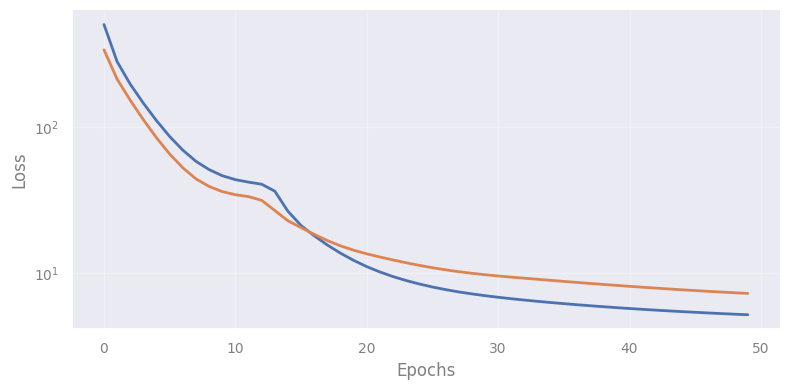

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
Mean Squared Error (test): 4.58


In [42]:
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

yhat_test = model.predict(X_test)

# Evaluate the model
MSE_test = mean_squared_error(y_test, yhat_test)
print("Mean Squared Error (test): %.2f" % MSE_test)

<u>**Remark on return_sequences**</u>:

Let’s say we process a batch of **3 samples** (windows), each with **4 timesteps** and **hidden_dim = 2**.

- If `return_sequences = True`:
  
> Returns ($h_t$, $h_{t-1}$, ... $h_{t-T}$) for each sample
  
```
Input:        x1  x2  x3  x4
Hidden States: 
              h1  h2  h3  h4   <-- All h1, h2, h3, h4 kept and passed forward (each has dimension 2)
              h1' h2' h3' h4'  
              h1'' h2'' h3'' h4''
Output shape: (#samples, #timesteps, hidden_dim) = (3, 4, 2)
```
- If `return_sequences = False`:

> Only returns the final state
  
```
Input:        x1  x2  x3  x4
Hidden States: 
              h1  h2  h3  h4       <-- Only h4 is kept (dimension 2)
              h1' h2' h3' h4'      <-- Only h4' is kept (dimension 2)
              h1'' h2'' h3'' h4''  <-- Only h4'' is kept (dimension 2)
Output shape: (#samples, hidden_dim) = (3, 2)
```

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

The `return_sequences = False` option is used when we want to **chain** multiple RNN cells:

Model: "A_Bit_Deeper_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_10 (RNN)                    │ (None, 5, 32)          │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_11 (RNN)                    │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

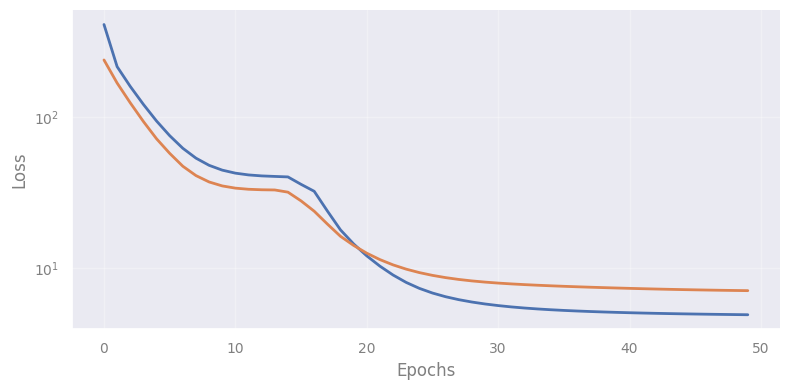

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
Mean Squared Error (test): 4.08


In [113]:
# Number of hidden units (neurons)
hidden_dim = 32

# Define model using an RNN cell inside an RNN layer
model = Sequential(name="A_Bit_Deeper_RNN")
model.add(RNN(SimpleRNNCell(hidden_dim), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(RNN(SimpleRNNCell(hidden_dim), input_shape=(hidden_dim)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32, verbose=0)

plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

yhat_test = model.predict(X_test)

# Evaluate the model
MSE_test = mean_squared_error(y_test, yhat_test)
print("Mean Squared Error (test): %.2f" % MSE_test)

<div class="alert alert-block alert-warning" style="margin-top: 20px">

##  In-class Exercise [20 min]

**Objective:** Try to get a better MSE score than above (on test!).

**Task:** Increase the complexity of the model.

_In particular, you must:_

1. **Copy-paste** the cell above
2. Keep the epochs **fixed** to 50
3. Then, you can try either (_or both_) of:
    - **Adding** Dense layers<br>
        &emsp;&emsp; _With as many neurons as you deem appropriate_
    - **Adding** RNN cells, and/or **changing** `hidden_dim`<br>
        &emsp;&emsp; _Don't forget to set_ `return_sequences=True` _if you follow up with another RNN cell!_

</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

_Our solution_

Model: "A_Bit_Deeper_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_14 (RNN)                    │ (None, 5, 16)          │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_15 (RNN)                    │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

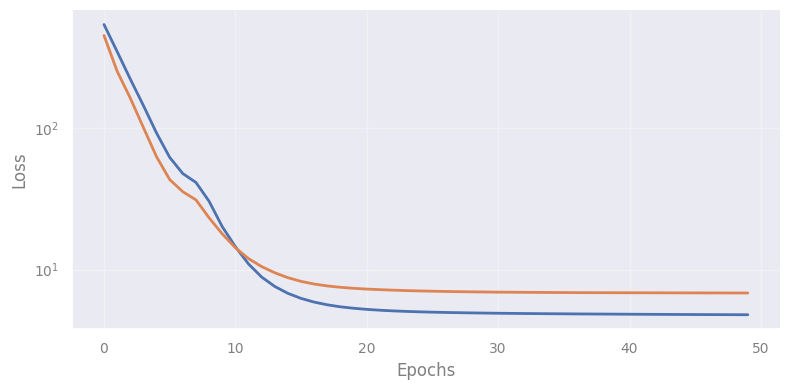

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
Mean Squared Error (test): 3.96


In [127]:
# Number of hidden units (neurons)
hidden_dim = 16

# Define model using an RNN cell inside an RNN layer
model = Sequential(name="A_Bit_Deeper_RNN")
model.add(RNN(SimpleRNNCell(hidden_dim), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(RNN(SimpleRNNCell(hidden_dim), input_shape=(hidden_dim), return_sequences=False))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32, verbose=0)

plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

yhat_test = model.predict(X_test)

# Evaluate the model
MSE_test = mean_squared_error(y_test, yhat_test)
print("Mean Squared Error (test): %.2f" % MSE_test)

# Predictions

Let's **visualize** the predictions.

We windowed the data using:
```python
win_predictor=5, win_target=1
```

This means that $-$ when we **predict** $-$ we need to pass the previous 5 timesteps to forecast the next:

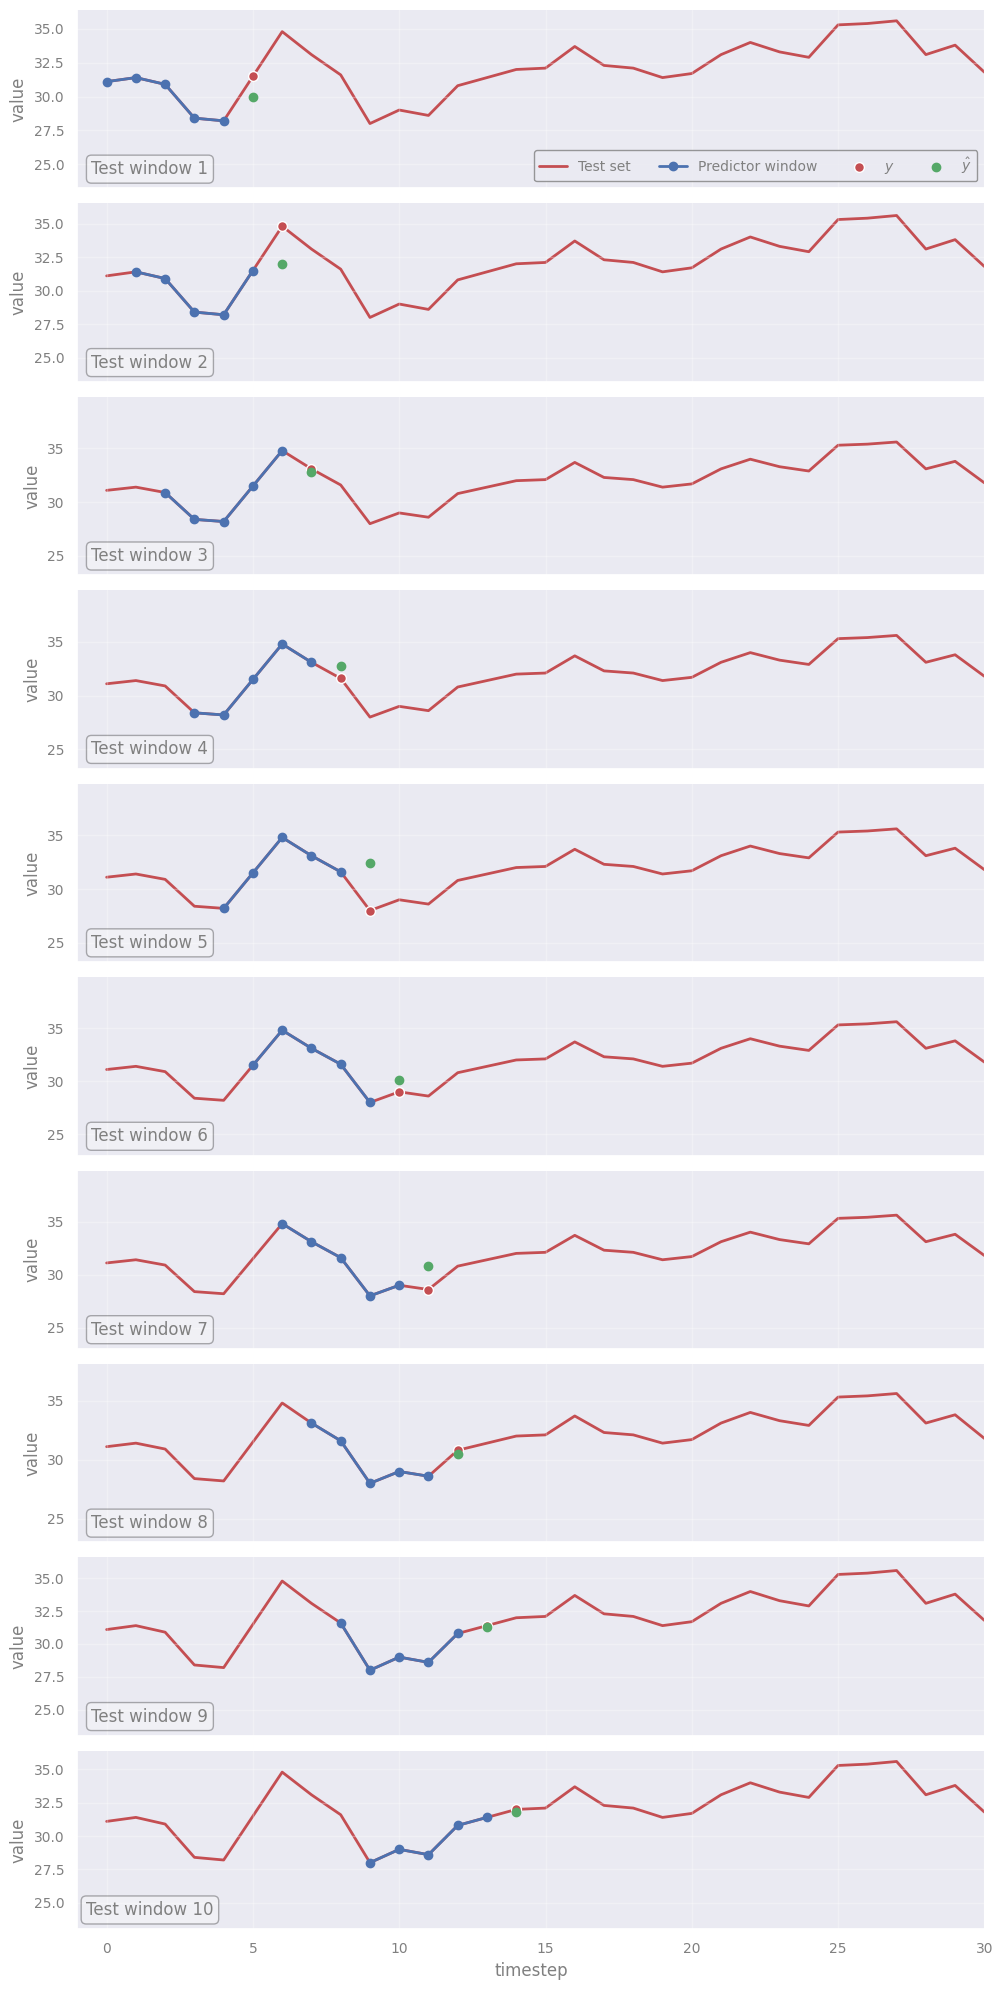

In [176]:
import matplotlib.pyplot as plt
import numpy as np

def plot_windows_predictions(series_test, X_test_2D, y_test, yhat_test, n_windows=5):
    """
    Plots input windows with corresponding target and prediction.
    
    Parameters:
    X_test_2D : np.array
        The input sequences (test set) of shape (num_samples, window_size,).
    y_test : np.array
        The true target values of shape (num_samples,).
    yhat_test : np.array
        The predicted target values of shape (num_samples,).
    n_windows : int, optional
        Number of windows to plot (default is 5).
    """
    n_windows = min(n_windows, len(X_test_2D))
    
    fig, axes = plt.subplots(n_windows, 1, figsize=(10, n_windows * 2), sharex=True)
    
    for i, ax in enumerate(axes):
        ax.plot(series_test, label='Test set', c='C3', zorder=-1)
        ax.plot(np.arange(i, i+len(X_test_2D[i])), X_test_2D[i, :], label='Predictor window', marker='o', c='C0')
        ax.scatter(i+len(X_test_2D[i]), y_test[i], color='C3', edgecolors='white', linewidth=1, s=50, label='$y$')
        ax.scatter(i+len(X_test_2D[i]), yhat_test[i], color='C2', label='$\hat{y}$')
        
        ax.text(0.08, 0.08, f"Test window {i+1}", fontsize=12, ha='center', transform=ax.transAxes,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.3))
        
        ax.set_ylabel("value")
        ax.set_xlim(-1, 30)
        ax.set_ylim(np.min(X_test_2D[i])-5, np.max(X_test_2D[i])+5)
        
        if i == 0:
            ax.legend(loc="lower right", ncols=4)
    
    axes[-1].set_xlabel("timestep")
    plt.tight_layout()
    plt.show()

plot_windows_predictions(series_test, X_test_2D, y_test, yhat_test, n_windows=10)

_Woah, not bad!_

$\rightarrow$ It looks like our predictions are **consistently close** to the true values!

_BUT ..._

For every prediction, we used a window from the **test set itself**.

**Q:** What if we want to predict for multiple timesteps $h$ into an unseen future?<br>
&emsp;&emsp; (_e.g., the temperatures for all days in the the next week_)

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<details>
    
<b><summary>[Spoiler] (click here to expand)</summary></b>  

**A:** Two options:

1. We **re-train** a model with an horizon equal to the desired one: ```python win_target = h```
2. We **roll** the predictions recursively

We will see the second option.
</details>
</div>

## Recursing predictions

In our case, the model predicts **only 1 future value** $\rightarrow$ $y_{t}$.

Let's call "$X_{prompt}$" the **window** at the current iteration $-$ the one we pass to the model to obtain $y_{t}$:<br>
&emsp;&emsp; $ \hat{y}_t = \text{model.predict}(X_{\text{prompt}}) $

Then, the pseudo-algorithm to **recurse the predictions** works as follows:

<u>**Algorithm**</u>

1. **Initialize** the prompt window: $X_{prompt} = X_{initial}$<br>
    ( _where $X_{initial}$ is the last available window in the set_ )<br>

2. **Iterate for each future step** $-$ from timestep $1$ to $h$:
   - **Step 1** $-$ Predict the next value using the trained model:<br>
     &emsp;&emsp; $ \hat{y}_t = \text{model.predict}(X_{\text{prompt}}) $
   - **Step 2** $-$ Store $\hat{y}_t$ in the forecast list
   - **Step 3** $-$ Append the predicted value to form the new input window:
     - Shift $X_{prompt}$ one step forward
     - Remove the first value in $X_{prompt}$
     - Append $\hat{y}_t$ as the last value in $X_{prompt}$

In [134]:
def recursive_forecast(model, X_initial, h):
    """
    Perform recursive multi-step forecasting.

    Parameters:
    model : Trained model
        The trained recurrent neural network.
    X_initial : np.array
        The initial input sequence (shape: [window_size, num_features]).
    h : int
        Number of future steps to predict.

    Returns:
    np.array
        The predicted values for the next `h` timesteps.
    """
    X_prompt = X_initial.copy()
    yhat_rolled = []

    for _ in range(h):
        pred = model.predict(X_prompt[np.newaxis, :, :], verbose=0)[0, 0]  # Predict next value
        yhat_rolled.append(pred)

        # Update input window: shift left and append prediction
        X_prompt = np.roll(X_prompt, shift=-1, axis=0)
        X_prompt[-1, 0] = pred  # Assuming first feature is the target variable

    return np.array(yhat_rolled)

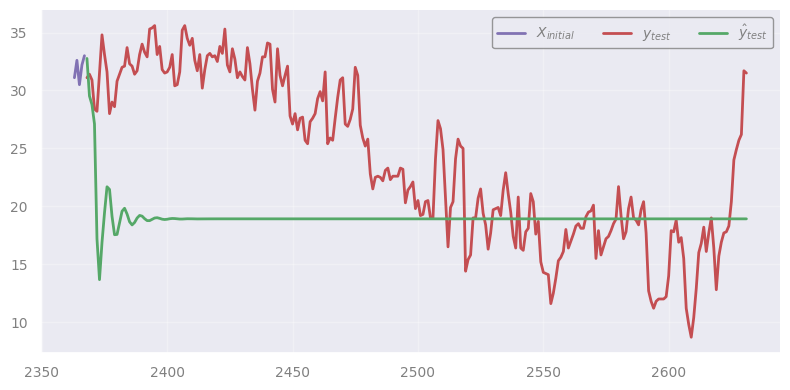

In [175]:
h = len(series_test)
'''We want to forecast for the whole test set ...'''
X_initial = X_valid[-1]
'''... so we start from the last available validation window.'''
yhat_rolled = recursive_forecast(model, X_initial, h)

plt.plot(np.arange(timesteps_test[0]-len(X_initial), timesteps_test[0]),\
         scaler.inverse_transform(X_initial.reshape(1, -1))[0], c='C4', label='$X_{initial}$')
plt.plot(timesteps_test,  series_test,  c='C3', label='$y_{test}$')
plt.plot(timesteps_test,  yhat_rolled,  c='C2', label='$\hat{y}_{test}$')
plt.legend(ncols=3)
plt.show()

_Woah, this looks ... not amazing_

<u>IMPORTANT</u>

> While the **next-in-time** predictions may be very accurate (_low MSE_) $-$ the **recursed** predictions (_and CI_) diverge very fast!

_PS: Just like ARMA models!_

$\rightarrow$ Predicting beyond a few timesteps is a **difficult** task!

## Predictions on the future beyond the data

With the train/validation/test protocol $\rightarrow$ we estimated the **performance**

If we now want to predict in **the future** ( _e.g., from tomorrow and on_ ) $\rightarrow$ we first need **re-train** on <u>all available data</u> ( _up to last timestep!_ ).

Model: "A_Bit_Deeper_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_14 (RNN)                    │ (None, 5, 16)          │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_15 (RNN)                    │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

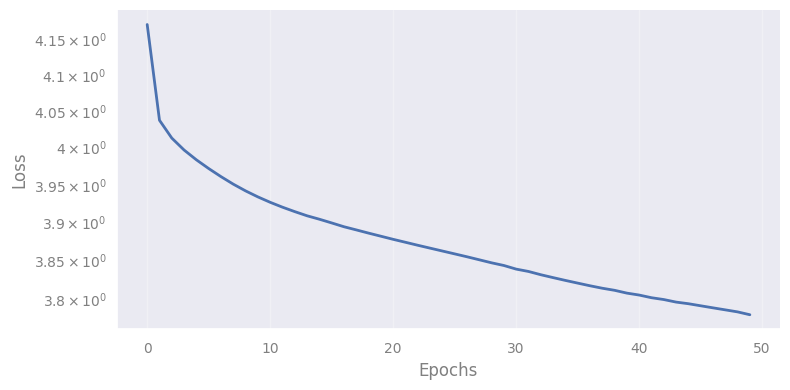

In [180]:
# Merge all windowed data
X = np.vstack((X_train, X_valid, X_test))
y = np.vstack((y_train, y_valid, y_test))

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X, y, epochs=50, batch_size=64, verbose=0)

plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

<div class="alert alert-block alert-warning" style="margin-top: 20px">

##  In-class Exercise [15 min]

**Objective:** Predict Heraklio's temperature for the next 7 days.

**Task:** Setup and run the rolling prediction, then compare against the values obtained via `Open-Meteo`.

**Hint:** Notice that we merged all the windows into `X`, so you need to grab `X_inital` from there.

</div>

In [218]:
import requests
import datetime

def fetch_heraklio_forecasts(yesterday):
    """Retrieve forecasted temperatures from Open-Meteo, for the next week"""

    url = "https://api.open-meteo.com/v1/forecast"
    
    # Coordinates for Heraklion, Greece
    latitude = 35.3387
    longitude = 25.1442
    
    # Convert yesterday to datetime and calculate the date range
    start_date = (datetime.datetime.strptime(yesterday, "%Y-%m-%d") + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    end_date = (datetime.datetime.strptime(yesterday, "%Y-%m-%d") + datetime.timedelta(days=7)).strftime("%Y-%m-%d")
    
    # Define the query parameters
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "daily": ["temperature_2m_min", "temperature_2m_max"],
        "timezone": "Europe/Athens",
        "start_date": start_date,
        "end_date": end_date
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        daily_forecast = data.get('daily', {})
        dates = daily_forecast.get('time', [])
        temp_max = daily_forecast.get('temperature_2m_max', [])
    
        print("Open-Meteo 7-Day forecast for Heraklion, Greece:")
        for date, t_max in zip(dates, temp_max):
            print(f"  {date} | Max Temp: {t_max}°C")
    else:
        print(f"Failed to retrieve data: {response.status_code}")

In [ ]:
############################################
# Replace "..." with the appropriate code! #
############################################
h = ...
X_initial = ...
yhat_rolled = ...
'''Hint: Scroll up until you see the cell where `yhat_rolled` is calculated.'''

plt.plot(np.arange(-len(X_initial), 0),\
         scaler.inverse_transform(X_initial.reshape(1, -1))[0], c='C4', label='$X_{initial}$')
plt.plot(np.arange(h), yhat_rolled, c='C2', label='$\hat{y}$')
plt.legend(ncols=2)
plt.show()

print(f"Model forecasts for the week following: {yesterday}")
print("\n".join([f"  {pd.to_datetime(yesterday) + pd.Timedelta(days=i+1):%Y-%m-%d} | Predicted: {round(float(item), 2)}°C"
                 for i, item in enumerate(yhat_rolled)]))
print()
fetch_heraklio_forecasts(yesterday)

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

_Our solution_

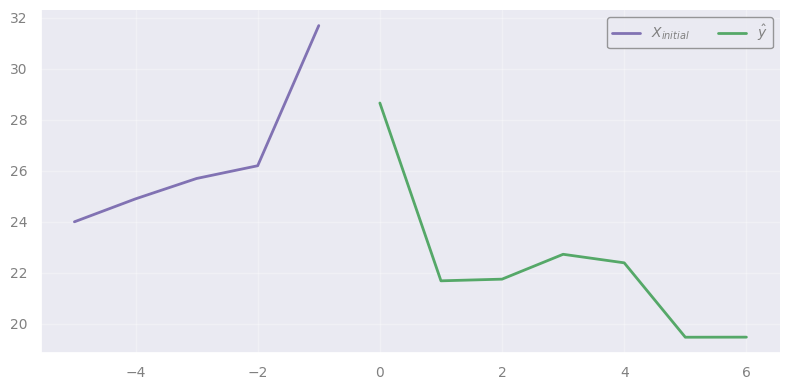

Model forecasts for the week following: 2025-03-17
  2025-03-18 | Predicted: 28.66°C
  2025-03-19 | Predicted: 21.68°C
  2025-03-20 | Predicted: 21.75°C
  2025-03-21 | Predicted: 22.72°C
  2025-03-22 | Predicted: 22.39°C
  2025-03-23 | Predicted: 19.47°C
  2025-03-24 | Predicted: 19.47°C

Open-Meteo 7-Day forecast for Heraklion, Greece:
  2025-03-18 | Max Temp: 18.6°C
  2025-03-19 | Max Temp: 12.6°C
  2025-03-20 | Max Temp: 12.7°C
  2025-03-21 | Max Temp: 14.8°C
  2025-03-22 | Max Temp: 16.7°C
  2025-03-23 | Max Temp: 21.4°C
  2025-03-24 | Max Temp: 27.0°C


In [219]:
h = 7
X_initial = X[-1]
yhat_rolled = recursive_forecast(model, X_initial, h)

plt.plot(np.arange(-len(X_initial), 0),\
         scaler.inverse_transform(X_initial.reshape(1, -1))[0], c='C4', label='$X_{initial}$')
plt.plot(np.arange(h), yhat_rolled, c='C2', label='$\hat{y}$')
plt.legend(ncols=2)
plt.show()

print(f"Model forecasts for the week following: {yesterday}")
print("\n".join([f"  {pd.to_datetime(yesterday) + pd.Timedelta(days=i+1):%Y-%m-%d} | Predicted: {round(float(item), 2)}°C"
                 for i, item in enumerate(yhat_rolled)]))
print()
fetch_heraklio_forecasts(yesterday)

<u>**Observations**</u>

- Maybe a **direct** 7-days ahead forecast would yield better results (i.e., train with `win_target` = 7)?
- Maybe **increasing** the number of features (`win_predictor`) would yield better results?

$\rightarrow$ _You can try at home / as project!_


# Estimate Uncertainties

Placing an uncertainty on a forecast is "industry standard" $-$ A forecast without CI is <u>not</u> trustworthy.

- Some models (_e.g. ARMA_) are **probabilistic** $\rightarrow$ uncertainties come "for free".
- Other models (_e.g. many ML ones_) only return **point predictions** $\rightarrow$ How we can place an uncertainty?

In ML, we often we need **heuristic methods** to get CIs $\rightarrow$ Here we will see 2 possible strategies based on sampling.

## Sampling Errors

This is a brute-force, yet simple method.

Let's say we have a model:
- trained on windows ( $t-w$, $t-w+1$, ..., $t$ ), and that
- predicts an horizon ( $t+1$, $t+2$, ..., $t+h$ ) of steps ahead.

Then:

> The uncertainty at each ( $t+n$ ) can be estimated by calculating the average prediction error observed at ( $t+n$ ) **during the training**.

Let's train a simple `LinearRegressor` with a **target window of 7**<br>
_PS: we will also increase the predictor window to 15, for this example_

In [280]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

win_predictor = 15
win_target = 7

# A. Train/Test split
train_size = int(0.8 * len(series))
series_train, series_test = series[:train_size], series[train_size:]

# B Windowing
X_train, y_train = windowing(series_train, win_predictor=win_predictor, win_target=win_target)
print('X_train: %-10s | y_train: %s' % (X_train.shape, y_train.shape))

# C. Define model
pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Because standardizing is always good habit!
    ("regressor", LinearRegression())
])

# D. Fit
pipeline.fit(X_train, y_train)
yhat_train = pipeline.predict(X_train)

X_train: (2084, 15) | y_train: (2084, 7)


Now we need to estimate the <u>standard deviation</u> of the errors **separately**, for each of the 15 features in $X$.

_PS: In place of the standard deviation we could use the average MAE (or whatever other reasonable metric)._

<div class="alert alert-block alert-warning" style="margin-top: 20px">

##  In-class Exercise [5 min]

**Task:** Calculate the standard deviation of the errors between `y_train` and `yhat_train`.

**Hint:** It's 1 line of code.
</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

_Our solution_

In [281]:
std_train = np.std(yhat_train - y_train, axis=0)
print('Shape of std_train: %s' % std_train.shape)  # Check dimension is the same as the target window

Shape of std_train: 7


These are the uncertainties for the `win_target` predicted points.

<div class="alert alert-block alert-warning" style="margin-top: 20px">

##  In-class Exercise [20 min]

**Task:** Plot the first prediction on the test set, along with its uncertainty.

_In particular, you must:_

1. **Grab** the last `win_predictor` (= 15) points in `series_train` (place them in `X_prompt` )
2. **Predict** the 7 targets passing `[X_prompt]` to `pipeline.predict(.)`<br>
    _NOTE: The "[" "]" are because sklearn always expects 2D inputs._<br>
    _NOTE: Similarly, remember that `predict(.)` will also generate 2D output!_<br>
    
3. **Plot**:
    - the prompt window
    - the predicted values
    - the uncertainties around them
    - the true test data (first 7 points in `series_test`)

**Hint:**

You can use `plt.fill_between(.)` to represent the uncertainty.

</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

_Our solution_

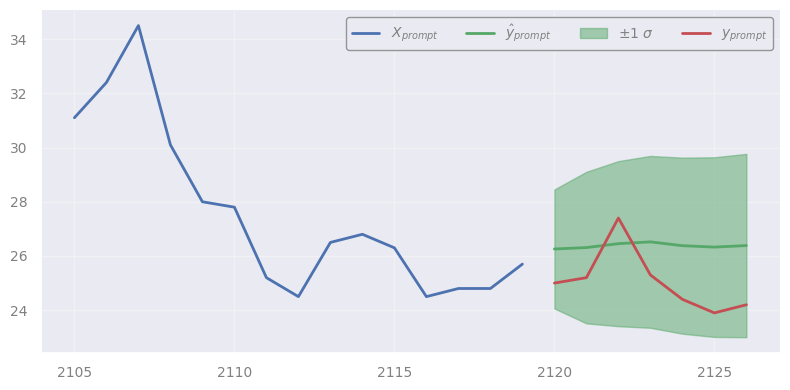

In [284]:
# 1. Grab prompt window
X_prompt = series_train[-win_predictor:]

# 2. Predict
yhat_prompt = pipeline.predict([X_prompt])[0]

# 3. Plot
timesteps_X = np.arange(win_predictor) + len(series_train)
timesteps_y = np.arange(win_predictor, win_predictor+win_target) + len(series_train)

plt.plot(timesteps_X, X_prompt,    c='C0', label='$X_{prompt}$')
plt.plot(timesteps_y, yhat_prompt, c='C2', label='$\hat{y}_{prompt}$')
plt.fill_between(timesteps_y, yhat_prompt - std_train, yhat_prompt + std_train, color="C2", alpha=0.5, label="±1 $\sigma$")
plt.plot(timesteps_y, series_test[:win_target], c='C3', label='${y}_{prompt}$')
#
plt.legend(ncols=4)
plt.show()

<u>**Remark**</u>

Remember that, when we forecast for the unseen future, we <u>don't have</u> a test set to compare with!

## Bootstrapping

> Another approach is to estimate the uncertainties by **re-training** the model on a different sub-sample of the data, and **re-predicting $B$ times**<br>
( _Bootstrapping_ )

**Problem:** We cannot re-sample series **simply at random**, because datapoints are correlated (_non-i.i.d._)!

**Intuition:** Ensure that the resampled data **preserve** key dependency structures.
<br><br>

## Maximum Entropy Bootstrapping (MEB)

> **MEB** is a resampling method that incorporates principles from Maximum Entropy.

It generates resampled data:
- **avoiding introducing** artificial structure, and
- remaining as **uninformative** (_max. entropy_) as possible beyond the constraints (_e.g., correlation_) given by the observed data

<u>**How it works**</u>

- Instead of drawing samples directly, MEB **assigns probabilistic weights to observations**
- These weights are chosen to **maximize entropy**

The maximization is subject to **constraints** derived from the observed dat $\rightarrow$ ensures that constraints (_e.g., autocorrelation_) are preserved

<u>**Mathematically**</u>  

MEB finds **probabilistic weights** $w_i$ that maximize entropy while preserving constraints.

We shall maximize the **Shannon entropy**:  

$$  
w^* = \arg\max_{w} \left( - \sum_{i=1}^{n} w_i \log w_i \right)  
\quad \text{subject to} \quad \sum_{i=1}^{n} w_i = 1  
$$  

and optional constraints (_e.g., preserving mean, autocorrelation_).

It is a <u>Constrained Optimization</u> problem $\rightarrow$ solved via **Lagrange Multipliers**

<u>**Sampling**</u>  

Using these weights, we draw bootstrap samples via **weighted resampling**:  

$$ X^*_b \sim P(X_i), \quad P(X_i) = w_i^*$$  

for each bootstrap replicate $b$.

$\rightarrow$ This ensures resampling maintains key statistical properties <u>without</u> assuming independence.


In [345]:
# DISCLAIMER: Quick ChatGPT implementation --- I wouldn't swear it works as intended!

import scipy.optimize as opt

def max_entropy_weights(data, lags=1):
    data = np.array(data) if isinstance(data, list) else data
    """
    Compute maximum entropy weights for bootstrapping while preserving autocorrelation constraints.
    """
    n = len(data)
    initial_w = np.ones(n) / n  # Start with uniform weights
    
    def entropy(w):
        return -np.sum(w * np.log(w))  # Shannon entropy
    
    def autocorr_constraint(w):
        mean_x = np.sum(w * data)
        x_centered = data - mean_x
        return np.dot(w[:-lags], x_centered[:-lags] * x_centered[lags:]) - np.corrcoef(data[:-lags], data[lags:])[0, 1]
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights must be 1
                   {'type': 'eq', 'fun': autocorr_constraint}]
    
    bounds = [(0, 1)] * n  # Probabilities must be between 0 and 1
    
    result = opt.minimize(lambda w: -entropy(w), initial_w, constraints=constraints, bounds=bounds)
    
    return result.x if result.success else initial_w

def meb_resample(data, B=100, lags=1):
    data = np.array(data) if isinstance(data, list) else data
    """
    Perform Maximum Entropy Bootstrapping on a time series while preserving autocorrelation.
    """
    n = len(data)
    boot_samples = np.zeros((B, n))
    
    weights = max_entropy_weights(data, lags)
    
    for b in range(B):
        indices = np.random.choice(np.arange(n), size=n, replace=True, p=weights)
        boot_samples[b] = data[indices]
    
    return boot_samples

This is very **computationally intensive**, so we will try it on a restricted series:

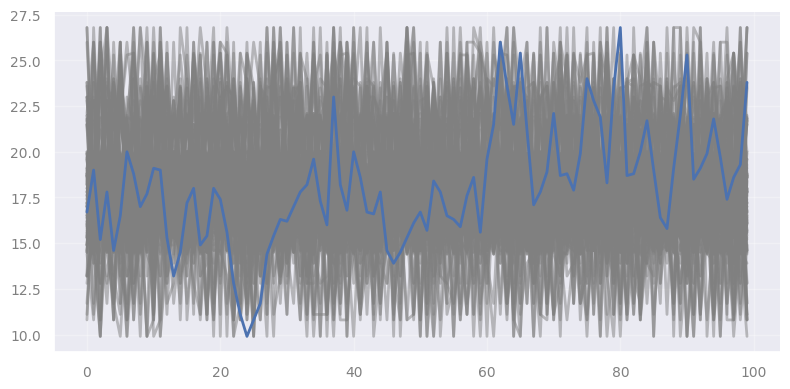

CPU times: user 837 ms, sys: 1.59 ms, total: 839 ms
Wall time: 838 ms


In [353]:
%%time
n_datapoints = 100
series_train_small = series[:n_datapoints]

# Sampling series
bootstrap_samples = meb_resample(series_train_small, B=100, lags=1)
for bootstrap_sample in bootstrap_samples:
    plt.plot(bootstrap_sample, c='grey', alpha=0.5)

plt.plot(series_train_small)
plt.show()

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

By re-training on **every bootstrapped** series, and re-running the prediction, we can obtain a "cloud" of uncertainy:

_PS: No, ChatGPT doesn't work!, so the bootstrapped results are not around the true data!_

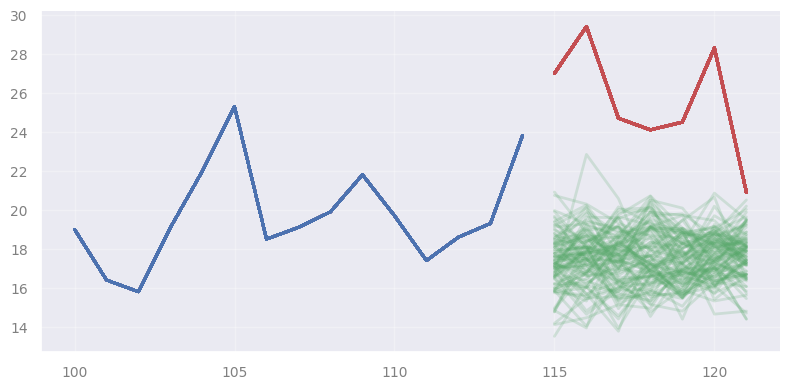

In [355]:
win_predictor = 15
win_target = 7

X_prompt = series_train_small[-win_predictor:]
'''
We always use the true data as prompt, not the bootstrapped.
The bootstrapped are only using to re-train the model.
'''

for bootstrap_sample in bootstrap_samples:

    # A Windowing
    X_train, y_train = windowing(bootstrap_sample, win_predictor=win_predictor, win_target=win_target)
    # print('X_train: %-10s | y_train: %s' % (X_train.shape, y_train.shape))
    
    # B. Define model
    pipeline = Pipeline([
        ("scaler", StandardScaler()),  # Because standardizing is always good habit!
        ("regressor", LinearRegression())
    ])
    
    # C. Fit
    pipeline.fit(X_train, y_train)

    # D. Predict on prompt
    yhat_prompt = pipeline.predict([X_prompt])[0]
    
    # E. Add current prediction to plot
    timesteps_X = np.arange(win_predictor) + len(series_train_small)
    timesteps_y = np.arange(win_predictor, win_predictor+win_target) + len(series_train_small)
    
    plt.plot(timesteps_X, X_prompt,    c='C0', alpha=0.2, label='$X_{prompt}$')
    plt.plot(timesteps_y, yhat_prompt, c='C2', alpha=0.2, label='$\hat{y}_{prompt}$')
    plt.plot(timesteps_y, series[n_datapoints:n_datapoints+win_target], c='C3', label='${y}_{prompt}$')

plt.show()

In [ ]:
#EOF

In [ ]:
#EOF